Read header and print it

In [1]:
# header
from flopa.io.loader import read_ptu_file

file_path = '../test_data/B16par_10.ptu'

ptu_data = read_ptu_file(file_path, verbose=True, header=False)


* WARNING: Not an image. Configure scanning settings.
--- Key Parameters ---
Repetition Rate:   8.00e+07 Hz
TCSPC Resolution:  3.20e-11 s
TCSPC Bins:        391
Wrap Around:       1024
Omega:             1.6083e-02 rad/s

--- Image Header ---
Pixels X:          N/A
Pixels Y:          N/A
Frame Count:       N/A


In [2]:
import os

file_size_bytes = os.path.getsize(ptu_data['reader'].path)
data_size_bytes = file_size_bytes - ptu_data['reader'].offset
bytes_per_record = ptu_data['reader'].bits // 8
total_records = data_size_bytes // bytes_per_record
total_records

7447989

In [3]:
# Access constants programmatically
print(ptu_data["constants"]["omega"])
print(ptu_data["constants"]["repetition_rate"])

0.016082654173639375
79988560


In [4]:
# markers

from flopa.io.loader import get_markers, read_ptu_file, analyze_marker_distribution

file_path = '../test_data/B16par_10.ptu'

ptu_data = read_ptu_file(file_path, verbose=False)

markers = get_markers(ptu_data["reader"])
print(markers)

print("_____")
dist = analyze_marker_distribution(markers, verbose=True)

print("_____")
dist 


{1: 49152, 2: 49152, 4: 3}
_____
--- Marker Analysis Suggestions ---
Frame Starts: 3 | Line Starts: 49152
For 3 frame(s) ~ 16384 line scans per frame.

Possible combinations: Lines x Accumulations
  - 4096 x 4
  - 2048 x 8
  - 1024 x 16
  - 512 x 32
  - 256 x 64
_____


{'num_line_starts': 49152,
 'num_frame_starts': 3,
 'frames_guess': 3,
 'total_lines_per_frame': 16384,
 'suggestions': [(4096, 4), (2048, 8), (1024, 16), (512, 32), (256, 64)]}

TCSPC channel overflow detected! Max channel: 24147
Channel overflow detected! Max channel: 50
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 392
TCSPC channel overflow detected! Max channel: 392
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 391
(3, 1, 1024, 1024, 2)


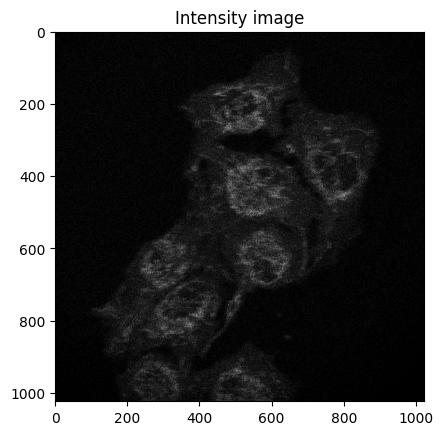

In [5]:
from flopa.io.loader import read_ptu_file
from flopa.io.ptuio.reconstructor import ImageReconstructor, ScanConfig
from flopa.io.ptuio.decoder import T3OverflowCorrector

import matplotlib.pyplot as plt


file_path = '../test_data/B16par_10.ptu'
ptu_data = read_ptu_file(file_path, verbose=False)

cfg = ScanConfig(
    bidirectional=True, 
    frames= 3,
    lines=1024, 
    pixels=1024, 
    line_accumulations= (16,),
    max_detector=2
    )

reconstructor = ImageReconstructor(
        config=cfg, 
        omega=ptu_data["constants"]["omega"],
        tcspc_channels=ptu_data["constants"]["tcspc_bins"],
        outputs=['photon_count']
        )

corrector = T3OverflowCorrector(wraparound=ptu_data["constants"]["wrap"])

for chunk in ptu_data["reader"].iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()
image = result.photon_count
print(image.shape)
image_slice = image.isel(frame=0,sequence=0,channel=0)

fig, ax = plt.subplots()
ax.imshow(image_slice,cmap='gray')
ax.set_title('Intensity image')
plt.show()


In [2]:
# In your Jupyter Notebook

# 1. Imports
from flopa.io.loader import read_ptu_file
from flopa.processing.reconstruction import reconstruct_ptu_to_dataset
from flopa.io.ptuio.reconstructor import ScanConfig

# --- STEP 1: I/O Operation (do this only once) ---
file_path = '../test_data/B16par_10.ptu'
ptu_data = read_ptu_file(file_path, verbose=False) # Set verbose to see header info

# --- STEP 2: Define Config and Run Computation ---
cfg = ScanConfig(
    bidirectional=True, 
    frames=3,
    lines=1024, 
    pixels=1024, 
    line_accumulations=(16,),
    max_detector=2
)

# Call the processing function with the loaded data
# It will show a tqdm progress bar because verbose=True
result = reconstruct_ptu_to_dataset(
    ptu_data=ptu_data,
    scan_config=cfg,
    outputs=['mean_arrival_time'], #mean_arrival_time
    verbose=True 
)

# 4. Use the result

image = result.photon_count
image_slice = image.isel(frame=0,sequence=0,channel=0)
image.shape

c:\Users\zuzka\miniforge3\envs\flopa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Reconstructing:   0%|          | 0/7447987 [00:00<?, ? records/s]

TCSPC channel overflow detected! Max channel: 24147
Channel overflow detected! Max channel: 50


Reconstructing:  13%|█▎        | 1000000/7447987 [00:00<00:02, 2545005.53 records/s]

TCSPC channel overflow detected! Max channel: 391


Reconstructing:  27%|██▋       | 2000000/7447987 [00:00<00:02, 2595206.38 records/s]

TCSPC channel overflow detected! Max channel: 392


Reconstructing:  40%|████      | 3000000/7447987 [00:01<00:01, 2233572.50 records/s]

TCSPC channel overflow detected! Max channel: 392


Reconstructing:  67%|██████▋   | 5000000/7447987 [00:02<00:01, 2361368.75 records/s]

TCSPC channel overflow detected! Max channel: 391


Reconstructing:  81%|████████  | 6000000/7447987 [00:02<00:00, 2399666.39 records/s]

TCSPC channel overflow detected! Max channel: 391


Reconstructing: 7447989 records [00:03, 2385401.88 records/s]                       

TCSPC channel overflow detected! Max channel: 391


(3, 1, 1024, 1024, 2)

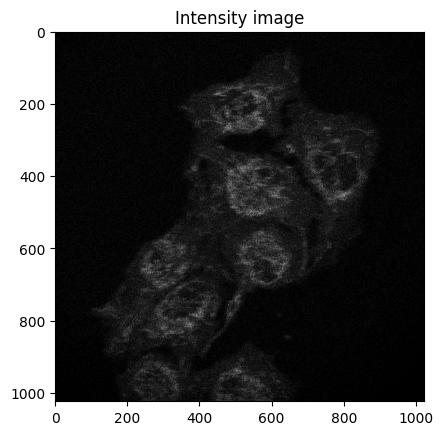

In [3]:
import matplotlib.pyplot as plt
image_slice = image.isel(frame=0,sequence=0,channel=0)

fig, ax = plt.subplots()
ax.imshow(image_slice,cmap='gray')
ax.set_title('Intensity image')
plt.show()

Read just masked area

In [1]:
import tifffile
from flopa.io.loader import read_ptu_file
from flopa.io.ptuio.reconstructor import ImageReconstructor, ScanConfig
from flopa.io.ptuio.decoder import T3OverflowCorrector

import matplotlib.pyplot as plt

roi = tifffile.imread('../test_data/Labels.tif')
print(roi.shape)

file_path = '../test_data/B16par_10.ptu'
ptu_data = read_ptu_file(file_path, verbose=False)

cfg = ScanConfig(
    bidirectional=True, 
    frames= 3,
    lines=1024, 
    pixels=1024, 
    line_accumulations= (16,),
    max_detector=2
    )

reconstructor = ImageReconstructor(
        config=cfg, 
        omega=ptu_data["constants"]["omega"],
        roi_mask=roi, 
        tcspc_channels=ptu_data["constants"]["tcspc_bins"],
        outputs=['mean_arrival_time']
        )

corrector = T3OverflowCorrector(wraparound=ptu_data["constants"]["wrap"])

for chunk in ptu_data["reader"].iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()
image = result.photon_count
image_slice = image.isel(frame=0,sequence=0,channel=0)

fig, ax = plt.subplots()
ax.imshow(image_slice,cmap='gray')
ax.set_title('Intensity image')
plt.show()


(1024, 1024)
TCSPC channel overflow detected! Max channel: 24147
Channel overflow detected! Max channel: 50
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 392
TCSPC channel overflow detected! Max channel: 392
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 391


AttributeError: 'Dataset' object has no attribute 'photon_count'

Estimate bi-directional scan phase shift

In [2]:
from flopa.io.ptuio.utils import estimate_bidirectional_shift
from flopa.io.ptuio.reconstructor import ScanConfig
from flopa.io.ptuio.reconstructor import ImageReconstructor
from flopa.io.ptuio.utils import estimate_tcspc_bins
from flopa.io.ptuio.decoder import T3OverflowCorrector
import numpy as np
import matplotlib.pyplot as plt

file_path = '../test_data/B16par_10.ptu'

ptu_data = read_ptu_file(file_path, verbose=False)
reader = ptu_data["reader"]


#corrector = T3OverflowCorrector(wraparound=wrap)
omega = ptu_data["constants"]["omega"]
tcspc_bins = ptu_data["constants"]["tcspc_bins"]
wrap = reader.header.tags.get("TTResultFormat_WrapAround", 1024)  # default fallback
corrector = T3OverflowCorrector(wraparound=wrap)

print(omega, tcspc_bins)
cfg = ScanConfig(
    bidirectional=True, 
    frames= 3,
    lines=1024, 
    pixels=1024, 
    line_accumulations= (16,),
    max_detector=2
    )

    
estimated_phase = estimate_bidirectional_shift(
        reader=reader,
        config=cfg,
        # roi_mask=roi # if roi is given, it is actually slower. Maybe deprecate and do estimation just on the first chunk?
    )



0.016082654173639375 391
Estimating bidirectional phase shift...
Channel overflow detected! Max channel: 50
Shift -0.0100 → score 160611.91
Channel overflow detected! Max channel: 50
Shift -0.0080 → score 162614.12
Channel overflow detected! Max channel: 50
Shift -0.0060 → score 164946.22
Channel overflow detected! Max channel: 50
Shift -0.0040 → score 172098.23
Channel overflow detected! Max channel: 50
Shift -0.0020 → score 177052.94
Channel overflow detected! Max channel: 50
Shift 0.0000 → score 183653.47
Channel overflow detected! Max channel: 50
Shift 0.0020 → score 191091.98
Channel overflow detected! Max channel: 50
Shift 0.0040 → score 205236.78
Channel overflow detected! Max channel: 50
Shift 0.0060 → score 221413.03
Channel overflow detected! Max channel: 50
Shift 0.0080 → score 219419.42
Channel overflow detected! Max channel: 50
Shift 0.0100 → score 200783.06
Best estimated shift: 0.00666


In [22]:
estimated_phase

(0.006659188203640709,
 array([[-1.00000000e-02, -8.00000000e-03, -6.00000000e-03,
         -4.00000000e-03, -2.00000000e-03,  0.00000000e+00,
          2.00000000e-03,  4.00000000e-03,  6.00000000e-03,
          8.00000000e-03,  1.00000000e-02],
        [ 1.60611906e+05,  1.62614125e+05,  1.64946219e+05,
          1.72098234e+05,  1.77052938e+05,  1.83653469e+05,
          1.91091984e+05,  2.05236781e+05,  2.21413031e+05,
          2.19419422e+05,  2.00783062e+05],
        [ 1.64482268e+05,  1.64664192e+05,  1.65351159e+05,
          1.67429244e+05,  1.72424384e+05,  1.81833746e+05,
          1.95357128e+05,  2.09284619e+05,  2.17521410e+05,
          2.15714333e+05,  2.04858689e+05]]))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

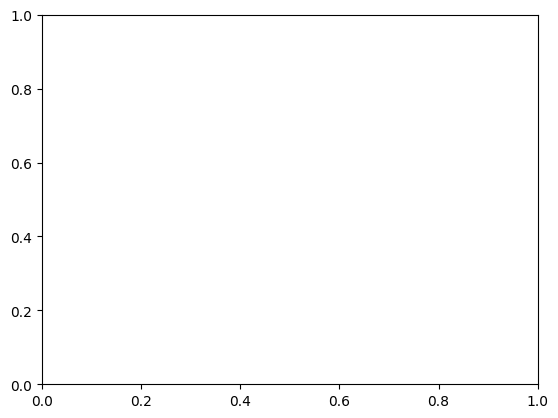

In [11]:
best_shift, plot_data = estimated_phase

cfg.bidirectional_phase_shift, params = estimated_phase

# 3. Create the plot using the dictionary keys
_, ax = plt.subplots()

# The x-axis data is in the 'shifts' key
x_values = plot_data['shifts']

# The y-axis data for the black dots is in the 'scores' key
y_scores = plot_data['scores']

# The y-axis data for the red fit curve is in the 'fit' key
y_fit = plot_data['fit']

# Plot the data points (black dots)
ax.plot(x_values, y_scores, color='black', marker='o', linestyle='')

# Plot the fit curve (red line), but only if the fit was successful
if y_fit is not None:
    ax.plot(x_values, y_fit, color='red', linestyle='-')

ax.set_title('Correlation vs shift')
plt.show()

In [1]:
from flopa.io.ptuio.utils import estimate_bidirectional_shift

estimated_phase = estimate_bidirectional_shift(
        reader=reader,
        config=cfg,
        # roi_mask=roi # if roi is given, it is actually slower. Maybe deprecate and do estimation just on the first chunk?
    )

cfg.bidirectional_phase_shift, scores = estimated_phase
_, ax = plt.subplots()
ax.plot(scores[0],scores[1],color='black',marker='o',linestyle='')
ax.plot(scores[0],scores[2],color='red',linestyle='-')
ax.set_title('Correlation vs shift')
plt.show()


NameError: name 'reader' is not defined

Reconstruct FLIM image with extimated optimized shift

In [ ]:
# For FLIM image you need both intensity and lifetime image -> specify those in outputs parameter
reconstructor = ImageReconstructor(
        config=cfg, 
        omega=omega, 
        tcspc_channels= tcspc_bins,
        outputs=['photon_count','mean_arrival_time']
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()


In [ ]:
from ptuio.utils import create_FLIM_image
import matplotlib.colors as mcolors
colormap = mcolors.LinearSegmentedColormap.from_list("green_red", ["green", "red"])

FLIM_image = create_FLIM_image(mean_photon_arrival_time=result.mean_arrival_time.isel(frame=0,sequence=0,channel=0).values * TCSPCresol * 1e9, 
                               intensity=result.photon_count.isel(frame=0,sequence=0,channel=0).values, 
                               lt_min=1, 
                               lt_max = 5,
                               int_min=0,
                               int_max=10,
                               colormap=colormap)

fig, ax = plt.subplots()
ax.imshow(FLIM_image)
ax.set_title('FLIM image with phase corrected')
plt.show()


Read image acquired with mono-directional scan

In [19]:
from flopa.io.ptuio.utils import estimate_bidirectional_shift
from flopa.io.ptuio.reconstructor import ScanConfig
from flopa.io.ptuio.reconstructor import ImageReconstructor
from flopa.io.ptuio.utils import estimate_tcspc_bins
from flopa.io.loader import read_ptu_file
from flopa.io.ptuio.decoder import T3OverflowCorrector
import numpy as np
import matplotlib.pyplot as plt

file_path = '../test_data/MultiHarp150_2025-06-18_16-37-45.274_f4_ch1_accu1__ch2_accu3_px500.ptu'

ptu_data = read_ptu_file(file_path, verbose=True, header=True)
reader = ptu_data["reader"]



TypeError: sequence item 8: expected str instance, NoneType found

Here the image data is saved in the header, but accumulations and sequence configuration is not. So it must be known or guessed...

In [14]:
cfg = ScanConfig(
    bidirectional=True, 
    frames= 3,
    lines=500, 
    pixels=500, 
    line_accumulations= (1,3),
    max_detector=2
    )

wrap = reader.header.tags.get("TTResultFormat_WrapAround", 1024)  # default fallback
repetition_rate = reader.header.tags.get("TTResult_SyncRate",40e6)  
tcspc_resolution = reader.header.tags.get("MeasDesc_Resolution",5e-12)
tcspc_bins = estimate_tcspc_bins(reader.header.tags,buffer=0)
TCSPCresol = reader.header.tags.get("MeasDesc_Resolution")

corrector = T3OverflowCorrector(wraparound=wrap)
omega = 2 * np.pi * repetition_rate * tcspc_resolution # should be in channel units

reconstructor = ImageReconstructor(
        config=cfg, 
        omega=omega, 
        tcspc_channels= tcspc_bins,
        outputs=None # this will read everything
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()




TCSPC channel overflow detected! Max channel: 5104
TCSPC channel overflow detected! Max channel: 5035
TCSPC channel overflow detected! Max channel: 5058
TCSPC channel overflow detected! Max channel: 5035
TCSPC channel overflow detected! Max channel: 5052
TCSPC channel overflow detected! Max channel: 5041
TCSPC channel overflow detected! Max channel: 5096
TCSPC channel overflow detected! Max channel: 5042
TCSPC channel overflow detected! Max channel: 5036
TCSPC channel overflow detected! Max channel: 5047
TCSPC channel overflow detected! Max channel: 5053
TCSPC channel overflow detected! Max channel: 5064
TCSPC channel overflow detected! Max channel: 5045
TCSPC channel overflow detected! Max channel: 5077
TCSPC channel overflow detected! Max channel: 5030


In [ ]:
FLIM_image = create_FLIM_image(mean_photon_arrival_time=result.mean_arrival_time.isel(frame=0,sequence=0,channel=0).values * TCSPCresol * 1e9, 
                               intensity=result.photon_count.isel(frame=0,sequence=0,channel=0).values, 
                               lt_min=1, 
                               lt_max = 5,
                               int_min=0,
                               int_max=10,
                               colormap=colormap)

fig, ax = plt.subplots()
ax.imshow(FLIM_image)
ax.set_title('FLIM image')
plt.show()

In [ ]:
dtimes = result.tcspc_channel.values * tcspc_resolution * 1e9
fig, ax = plt.subplots()
ax.semilogy(dtimes,result.tcspc_histogram.isel(frame=0,channel=0).values)
ax.semilogy(dtimes,result.tcspc_histogram.isel(frame=0,channel=1).values)
ax.set_xlabel('time [ns]')
ax.set_ylabel('photon count')
plt.show()